In [1]:
!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets,tree
from sklearn.tree import export_graphviz 
from sklearn import externals
from io import StringIO
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import pydotplus

In [3]:
df = pd.read_csv(r"/content/Company_Data.csv")
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [4]:
df1 = df.copy()

In [5]:
df1.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


In [6]:
df1.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

# Outlier Check

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


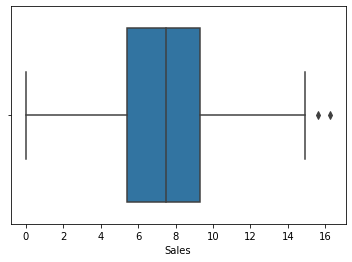

In [7]:
ax = sns.boxplot(df1['Sales'])
plt.show()

# The data has 2 outlier instances

In [8]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 0.18556036318721578
Kurtosis: -0.08087736743346197


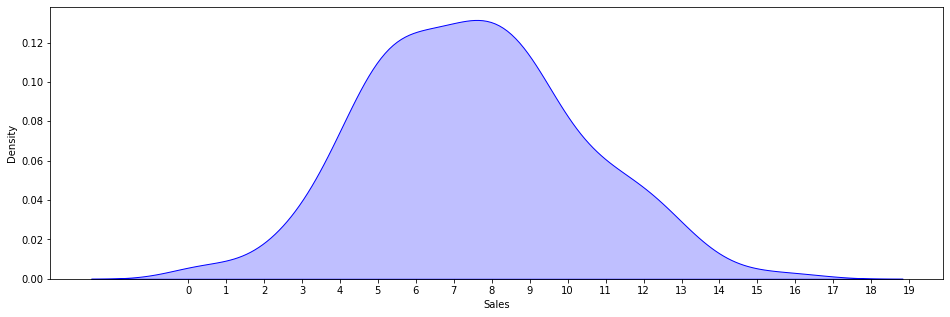

In [9]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['Sales'].skew()))
print("Kurtosis: {}".format(df1['Sales'].kurtosis()))
ax = sns.kdeplot(df1['Sales'],shade=True,color='b')
plt.xticks([i for i in range(0,20,1)])
plt.show()

# The data is Skwed on the right
# The data has negative Kurtosis

In [10]:
obj_colum = df1.select_dtypes(include='object').columns.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


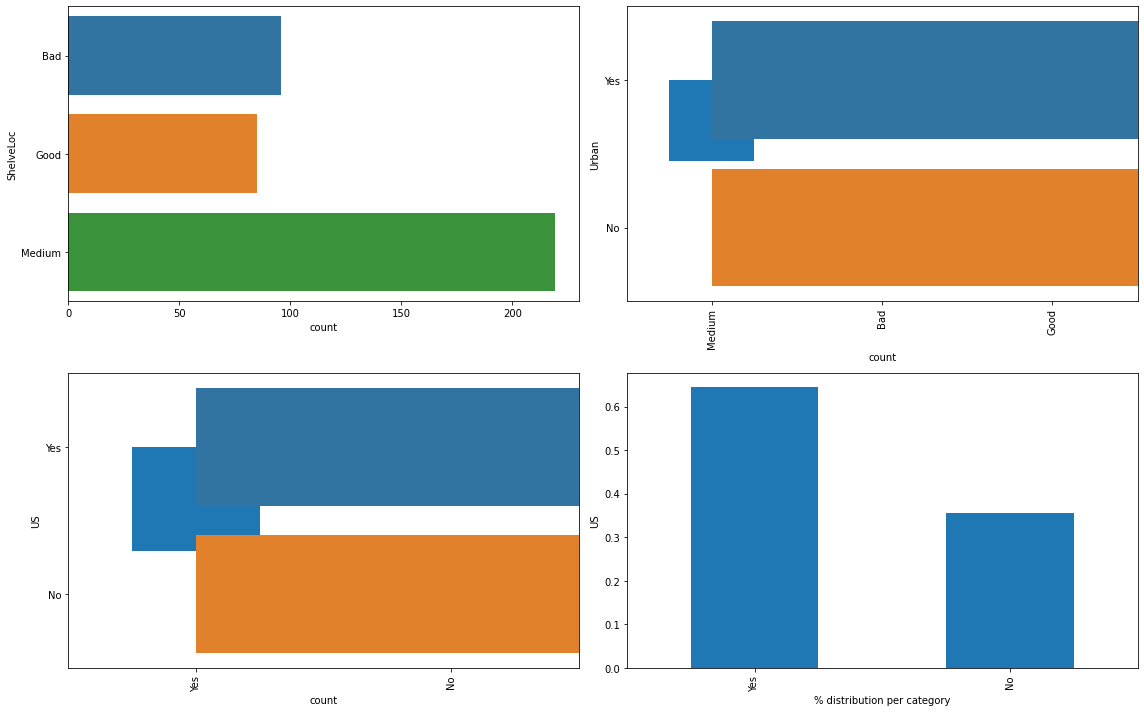

In [11]:
plt.figure(figsize=(16,10))
for i,col in enumerate(obj_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=df1,y=col)
    plt.subplot(2,2,i+1)
    df1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()  

In [12]:
num_columns = df1.select_dtypes(exclude='object').columns.tolist()

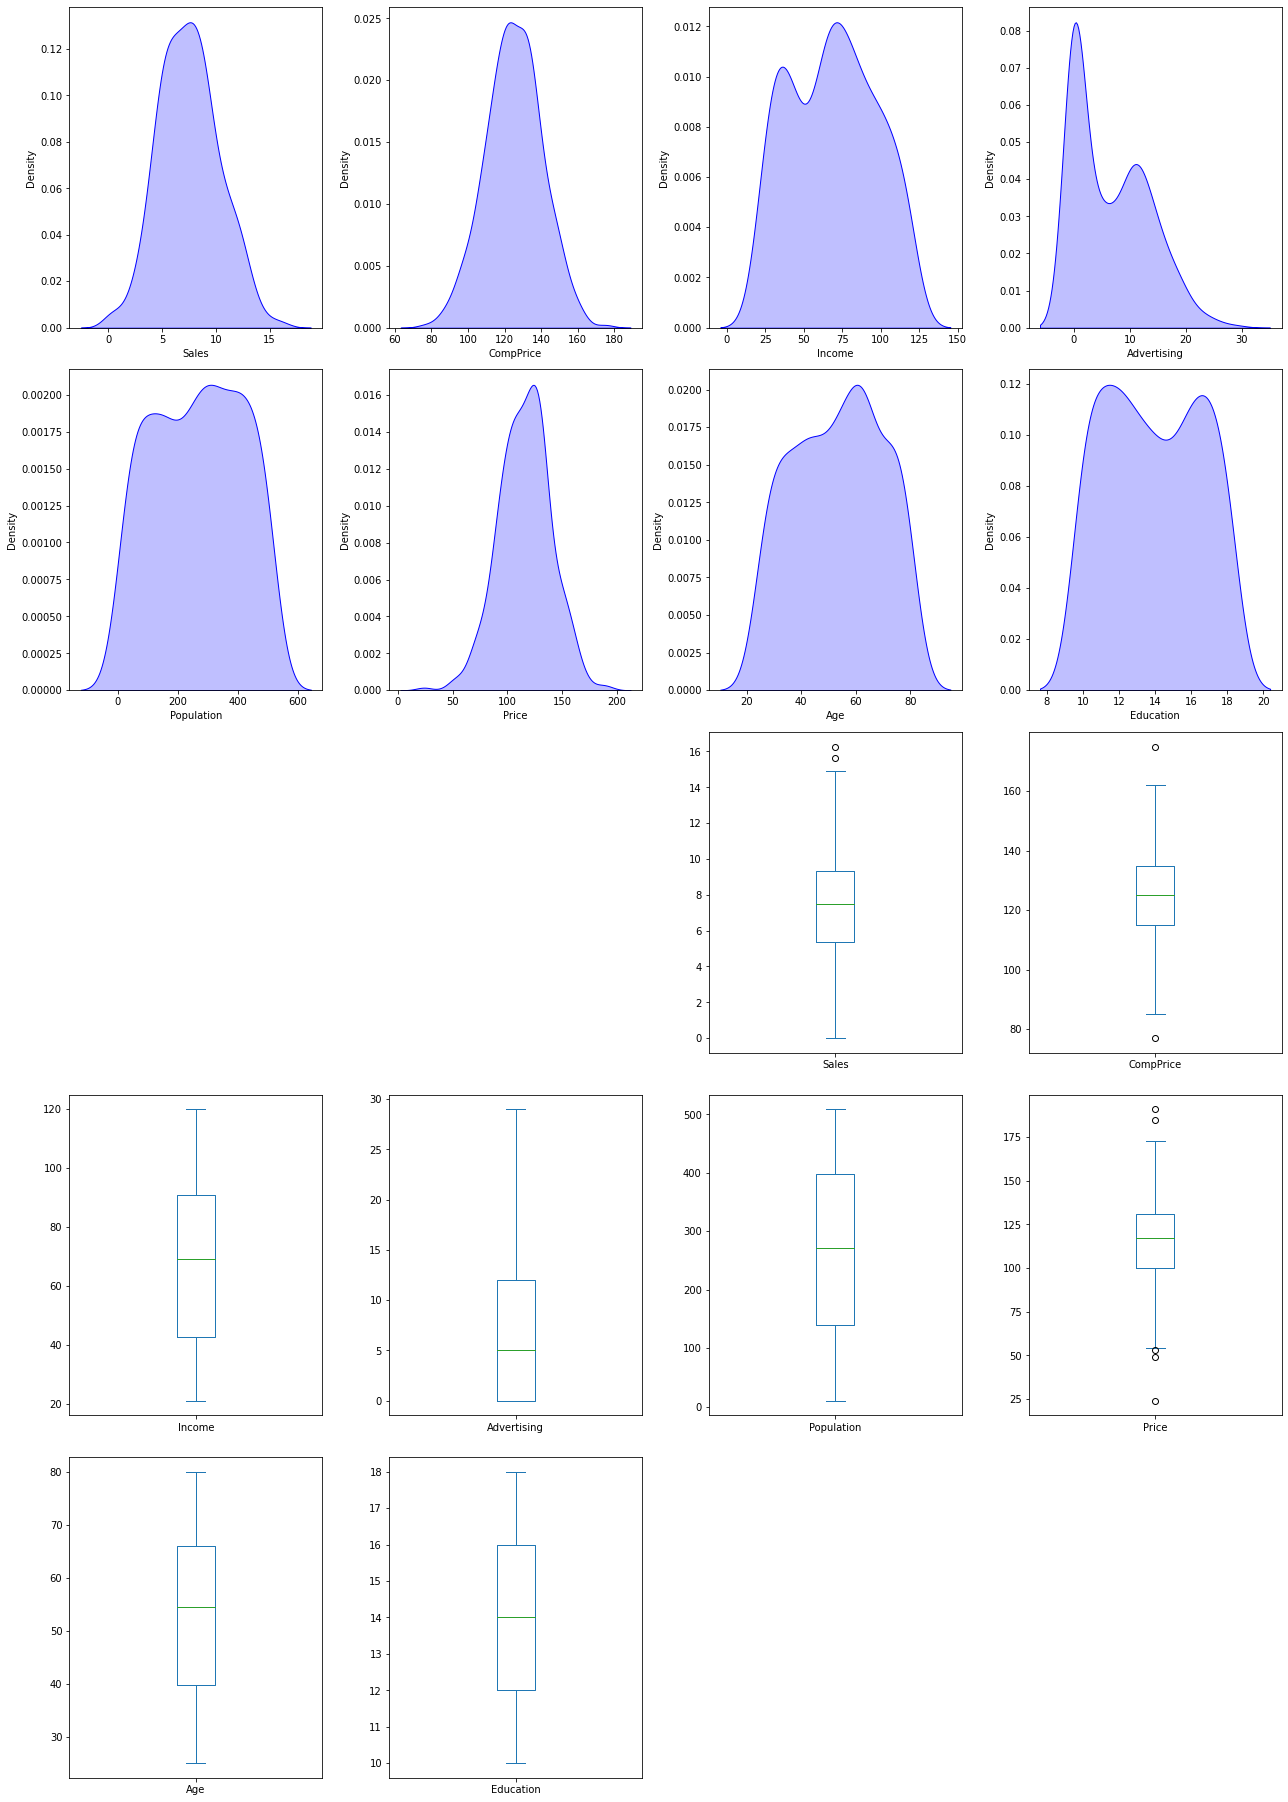

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
skewness,0.185560,-0.042755,0.049444,0.639586,-0.051227,-0.125286,-0.077182,0.044007
kurtosis,-0.080877,0.041666,-1.085289,-0.545118,-1.202318,0.451885,-1.134392,-1.298332


In [13]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='b',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])


In [14]:
corr = df1.corr()

In [15]:
df1 = pd.get_dummies(df1, columns = ['ShelveLoc','Urban','US'])


In [16]:
corr = df1.corr()

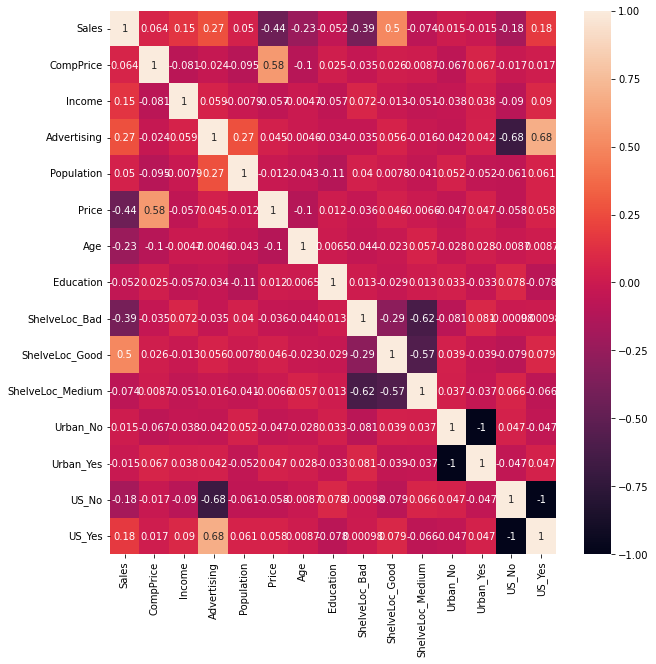

In [17]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)
plt.show()

# Random Forest Model
### Since the target variable is continious, we create a class of the value based on the mean
### <= 7.49 == "Small" and > 7.49 == "large"

In [18]:
df1["sales"]="small"
df1.loc[df1["Sales"]>7.49,"sales"]="large"
df1.drop(["Sales"],axis=1,inplace=True)

In [19]:
X = df1.iloc[:,0:14]
y = df1.iloc[:,14]

In [20]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)


In [21]:
y_train.value_counts()


large    161
small    159
Name: sales, dtype: int64

In [22]:
model =RF(n_jobs=4,n_estimators = 150, oob_score =True,criterion ='entropy') 
model.fit(x_train,y_train)
model.oob_score_

0.79375

In [23]:
pred_train = model.predict(x_train)

In [24]:
accuracy_score(y_train,pred_train)

1.0

In [25]:
confusion_matrix(y_train,pred_train)

array([[161,   0],
       [  0, 159]])

In [26]:

pred_test = model.predict(x_test)

In [27]:
accuracy_score(y_test,pred_test)

0.8125

In [28]:
confusion_matrix(y_test,pred_test)

array([[33,  5],
       [10, 32]])

In [29]:
df_t=pd.DataFrame({'Actual':y_test, 'Predicted':pred_test})

In [30]:
df_t.head()

,Actual,Predicted
103,small,small
153,small,large
251,small,small
326,small,large
258,small,small


In [31]:
cols = list(df1.columns)

In [32]:
predictors = cols[0:14]
target = cols[14]

In [33]:
tree1 = model.estimators_[20]

In [34]:
dot_data = StringIO()

In [35]:
export_graphviz(tree1, out_file = dot_data, feature_names =predictors, class_names = target, filled =True,rounded=True,impurity =False,proportion=False,precision =2)

In [36]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

#  Conclusion
### Since the accuracy of the Training set is 100% we test the accurancy on the test data which is 76%
### As seen in the confusion matrix of Test data 61 instances are presdected correctly and 19 instances are not

In [37]:
rf_small = RF(n_estimators=10, max_depth = 3)

In [38]:
rf_small.fit(x_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [39]:
tree_small = rf_small.estimators_[5]

In [40]:
export_graphviz(tree_small, out_file = dot_data, feature_names = predictors, rounded = True, precision = 1)

In [41]:
graph_small = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [42]:
model.feature_importances_

array([0.12961886, 0.10434596, 0.07962525, 0.08969033, 0.24878895,
       0.11592842, 0.05493221, 0.03782636, 0.06813098, 0.02180799,
       0.01313591, 0.01206529, 0.0110918 , 0.01301167])

In [43]:
fi = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [44]:
fi

,feature,importance
4,Price,0.248789
0,CompPrice,0.129619
5,Age,0.115928
1,Income,0.104346
3,Population,0.089690
2,Advertising,0.079625
8,ShelveLoc_Good,0.068131
6,Education,0.054932
7,ShelveLoc_Bad,0.037826
9,ShelveLoc_Medium,0.021808


# As seen in the above table Price is most important feature